In [1]:
# Доп. задание:  вместо binary_crossentropy использовать функцию потерь mean_squared_error
import tensorflow as tf
from tensorflow import keras
import numpy as np
print(tf.__version__)

2023-05-31 02:06:43.331881: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-31 02:06:43.395893: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-31 02:06:43.406540: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-31 02:06:45.374307: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


2.12.0


In [2]:
imdb = keras.datasets.imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

In [3]:
# Назначим словарь, который будет отображать слова из массива данных
word_index = imdb.get_word_index()

# Зарезервируем первые несколько значений
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2
# Вместо редких слов, не вошедших в набор из 10000, будет указано UNK
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [4]:
# Подготовка данных
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
value=word_index["<PAD>"],
padding='post',
maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data, value=word_index["<PAD>"],
padding='post',
maxlen=256)

In [5]:
# Создание модели
# Размер входных данных - количество слов, использованных в обзорах фильмов (10000 слов)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16, input_shape=(None,)))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160000    
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


In [6]:
# Определение функций потерь и оптимизатора
model.compile(optimizer='adam',
loss='mean_squared_error',
metrics=['accuracy'])


In [7]:
# Создание проверочного набора данных
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

In [8]:
# Обучение модели
history = model.fit(partial_x_train,
partial_y_train,
epochs=40,
batch_size=512,
validation_data=(x_val, y_val),
verbose=1)

2023-05-31 02:06:56.004177: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15360000 exceeds 10% of free system memory.


Epoch 1/40
30/30 [==============================] - 3s 48ms/step - loss: 0.2496 - accuracy: 0.5631 - val_loss: 0.2491 - val_accuracy: 0.5954
Epoch 2/40
30/30 [==============================] - 1s 32ms/step - loss: 0.2479 - accuracy: 0.6766 - val_loss: 0.2466 - val_accuracy: 0.6807
Epoch 3/40
30/30 [==============================] - 1s 32ms/step - loss: 0.2438 - accuracy: 0.7451 - val_loss: 0.2412 - val_accuracy: 0.7446
Epoch 4/40
30/30 [==============================] - 1s 34ms/step - loss: 0.2361 - accuracy: 0.7668 - val_loss: 0.2318 - val_accuracy: 0.7596
Epoch 5/40
30/30 [==============================] - 1s 30ms/step - loss: 0.2235 - accuracy: 0.7814 - val_loss: 0.2178 - val_accuracy: 0.7666
Epoch 6/40
30/30 [==============================] - 1s 33ms/step - loss: 0.2063 - accuracy: 0.8000 - val_loss: 0.2003 - val_accuracy: 0.7932
Epoch 7/40
30/30 [==============================] - 1s 31ms/step - loss: 0.1862 - accuracy: 0.8191 - val_loss: 0.1815 - val_accuracy: 0.8124
Epoch 8/40
30

In [9]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

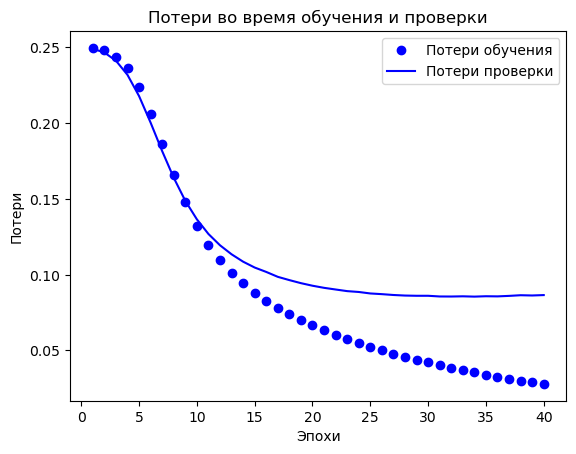

In [10]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" означает "blue dot", синяя точка
plt.plot(epochs, loss, 'bo', label='Потери обучения')
# "b" означает "solid blue line", непрерывная синяя линия
plt.plot(epochs, val_loss, 'b', label='Потери проверки')
plt.title('Потери во время обучения и проверки')
plt.xlabel('Эпохи')
plt.ylabel('Потери')
plt.legend()

plt.show()

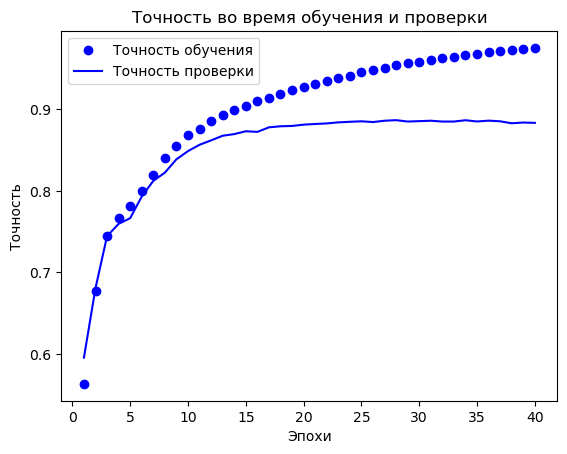

In [11]:
plt.clf() 
# Очистим график

plt.plot(epochs, acc, 'bo', label='Точность обучения')
plt.plot(epochs, val_acc, 'b', label='Точность проверки')
plt.title('Точность во время обучения и проверки')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()

In [12]:
# Оценка точности модели
results = model.evaluate(test_data, test_labels)
print(results)

  1/782 [..............................] - ETA: 41s - loss: 0.0851 - accuracy: 0.8750

2023-05-31 02:07:41.570773: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25600000 exceeds 10% of free system memory.


782/782 [==============================] - 3s 4ms/step - loss: 0.0931 - accuracy: 0.8744
[0.09313704818487167, 0.8743600249290466]


In [13]:
# Сохранение модели
model.save('model_Dop3_class.h5')
# Создание модели из сохраненного файла
new_model = keras.models.load_model('model_Dop3_class.h5')
# Проверим заданную модель из файла
loss, acc = new_model.evaluate(test_data, test_labels)
print("Восстановленная модель, точность: {:5.2f}%".format(100*acc))

  1/782 [..............................] - ETA: 1:47 - loss: 0.0851 - accuracy: 0.8750

2023-05-31 02:07:45.415066: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25600000 exceeds 10% of free system memory.


782/782 [==============================] - 4s 4ms/step - loss: 0.0931 - accuracy: 0.8744
Восстановленная модель, точность: 87.44%


In [14]:
# Сравним более наглядно точность старой модели относительно новой
loss , acc = model.evaluate(test_data, test_labels)
print("Изначальная модель, точность: {:5.2f}%".format(100*acc))

 10/782 [..............................] - ETA: 4s - loss: 0.0790 - accuracy: 0.8844 

2023-05-31 02:07:49.179697: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 25600000 exceeds 10% of free system memory.


782/782 [==============================] - 2s 3ms/step - loss: 0.0931 - accuracy: 0.8744
Изначальная модель, точность: 87.44%
